In [10]:
import torch
import numpy as np
import pandas as pd
import glob
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image 
from torchvision import datasets, models, transforms
import math 
import random 
import cv2
from PIL import Image
import pickle
import imageio
import cv2
import kornia as K
import kornia.geometry as KG
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from numpy.linalg import inv
from numpy.matlib import repmat
import torchvision.models as models
vgg = models.vgg16(pretrained=True)

base_dir = 'code/unspervised_vis_loc_reproduce/'

c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [109]:
zeros = np.zeros([ref1_depth.shape[0],ref1_depth.shape[1],16])

In [125]:
zeros[ref1_feature.shape[1:]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [129]:
zeros[:ref1_feature.shape[1],:ref1_feature.shape[2]].shape

(599, 799, 16)

In [133]:
ref1_depth.shape

torch.Size([600, 800])

In [128]:
ref1_feature.permute(1,2,0).detach().numpy().shape

(599, 799, 16)

In [145]:
zeros[:ref1_feature.shape[1],:ref1_feature.shape[2]] = ref1_feature.permute(1,2,0).detach().numpy()

In [146]:
zeros.shape

(600, 800, 16)

In [189]:
def image_to_point(feature,intrinsic, depth):
    depth_image = depth.detach().numpy()
    zeros = np.zeros((depth_image.shape[0],depth_image.shape[1],feature.shape[0]))
    zeros[:feature.shape[1],:feature.shape[2]] = feature.permute(1,2,0).detach().numpy()

    color = zeros
    pixel_length = depth_image.shape[0] * depth_image.shape[1]
    width = depth_image.shape[1]
    height = depth_image.shape[0]

    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, color.shape[2])
    normalized_depth = np.reshape(depth_image, pixel_length)

    # # Search for pixels where the depth is greater than max_depth to
    # # delete them
    # max_depth_indexes = np.where(normalized_depth > 0.9)
    # normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    # u_coord = np.delete(u_coord, max_depth_indexes)
    # v_coord = np.delete(v_coord, max_depth_indexes)
    # if color is not None:
    #     color = np.delete(color, max_depth_indexes, axis=0)
    
    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    inv_intrinsic = inv(intrinsic)
    p3d = np.dot(inv_intrinsic, p2d)
    # p3d = torch.mul(torch.from_numpy(p3d) , normalized_depth * 1000.0)
    p3d = p3d * normalized_depth * 1000.0

    return p3d.T ,color 
def inverse_E_point(point,extrinsic):
    if type(point) != np.ndarray:
        # print(point.shape)
        temp_p = torch.concat([point.reshape(-1,3),torch.ones(point.shape[0],1)],dim=1)
        inv_p = torch.inverse(extrinsic)@temp_p.T
        return inv_p[:3,:].T
    print(point.shape)
    temp_p = np.concatenate([point.reshape(-1,3), np.ones((point.shape[0], 1))], axis=1)
    inv_point = np.linalg.inv(extrinsic)@temp_p.T
    return inv_point.T[:, :3]

def point_to_image(point, intrinsic,height,width,featureMap):
    perspective_projection = point/(point[:,[-1]])
    # print(perspective_projection.shape)
    projected_points = (intrinsic@perspective_projection.T).T
    image = projected_points[:, :2]
    
    featureMap_temp = featureMap.reshape(-1,featureMap.shape[-1])

    feature = np.zeros((height,width,16))
    print(projected_points.shape)
    # color = color.reshape(-1,3)
    for i in range(image.shape[0]):
        # for dim in range(feature.shape[2]):
        try:
            feature[image[i,0].astype(int),image[i,1].astype(int),:] = featureMap_temp[i,dim]
        except:
            # print("image[{}]".format(i),image[i])
            continue

    return image,feature

In [12]:
class Carla_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = glob.glob(os.path.join(img_dir, '*.npz'))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.extrinsic_list = []
        self.intrinsic = 0
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels[idx])
        img_path = self.img_labels[idx]
        image_info = np.load(img_path)
        rgb_image = image_info['rgb']
        depth_image = image_info['depth']
        intrinsic = image_info['K']
        extrinsic = image_info['extrinsic']
        self.intrinsic = torch.from_numpy(intrinsic)
        self.extrinsic_list.append(torch.from_numpy(extrinsic))

        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = self.transform(depth_image)
        return torch.from_numpy(rgb_image), torch.from_numpy(depth_image)


In [20]:
dataset = Carla_Dataset(img_dir='carla_npzs')

In [94]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [22]:
#check loaded image and depth map
for image, depth in dataloader:
    print(image.shape)
    print(depth.shape)

    break

torch.Size([1, 600, 800, 3])
torch.Size([1, 600, 800])


In [16]:
vgg.avgpool = torch.nn.Identity()
vgg.features[30] = torch.nn.Identity()
for param in vgg.features:
    param.requires_grad = False

In [17]:
class Upsampling(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super(Upsampling, self).__init__()
        # print("in_channels: ",in_channels)
        # print("out_channels: ",out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                                     
    def forward(self, x1,x2,final = False):
        x1up = self.upsample(x1)
        # print("x1up?: ",x1up.shape)
        # print("x2.shape: ",x2.shape)
        if x1up.shape != x2.shape:
            x1up = torch.nn.functional.pad(x1up, (0, x2.shape[3] - x1up.shape[3], 0, x2.shape[2] - x1up.shape[2]))

        x = torch.cat([x2, x1up], dim=1)
        if final:
            output= torch.nn.Sequential(torch.nn.Conv2d(64+17, 17, kernel_size= 2, padding= 0,stride=1),
                                     torch.nn.BatchNorm2d(17),
                                     torch.nn.ReLU(True),
                                     
                                     torch.nn.Conv2d(17,17, kernel_size=1, padding= 0,stride=1),
                                     torch.nn.Sigmoid())(x)
            return output
        output = torch.nn.Sequential(torch.nn.Conv2d(self.in_channels, self.out_channels, kernel_size= 2, padding= 0,stride=1),
                                     torch.nn.BatchNorm2d(self.out_channels),
                                     torch.nn.ReLU(True),
                                     torch.nn.Conv2d(self.out_channels, self.out_channels, kernel_size= 2, padding= 0,stride=1),
                                     torch.nn.BatchNorm2d(self.out_channels),
                                     torch.nn.ReLU(True),
                                     torch.nn.Conv2d(self.out_channels, self.out_channels, kernel_size= 2, padding= 0,stride=1),
                                     torch.nn.BatchNorm2d(self.out_channels),
                                     torch.nn.ReLU(True))(x)
        

        return output

In [53]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.vgg = vgg

        self.up_1 = Upsampling(1024, 17)
        self.up_2 = Upsampling(256+17, 17)
        self.up_3 = Upsampling(128+17, 17)
        self.up_4 = Upsampling(64+17, 17)
        # self.up_4 =
        # self.outputs = LastConv(64+17, 17)
    
    def forward(self,x):
        x1 = self.vgg.features[0:4](x)
        x2 = self.vgg.features[4:9](x1)
        x3 = self.vgg.features[9:16](x2)
        x4 = self.vgg.features[16:23](x3)
        x5 = self.vgg.features[23:30](x4)


        x6 = self.up_1(x5,x4)
        x7 = self.up_2(x6,x3)
        x8 = self.up_3(x7,x2)
        x9 = self.up_4(x8,x1,True)

        # (F3,S3),(F2,S2),(F1,S1),(F0,S0)
        return (x6[0,:16],x6[0,16:]),(x7[0,:16],x7[0,16:]),(x8[0,:16],x8[0,16:]),(x9[0,:16],x9[0,16:])
        


In [54]:
featureMap = UNet(3,17)

In [55]:
(F3,S3),(F2,S2),(F1,S1),(F0,S0) = featureMap(dataset[0][0].float().permute(2,0,1).unsqueeze(0))

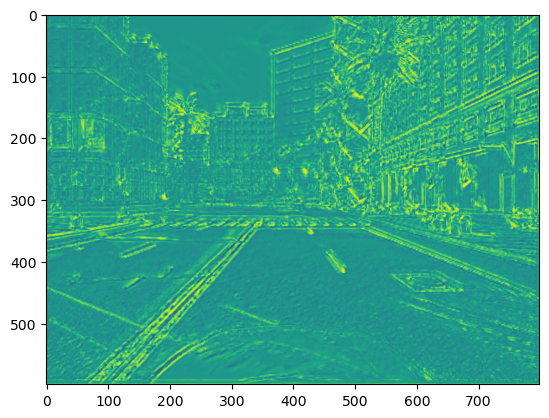

In [66]:
plt.imshow(S0.permute(1,2,0).detach().numpy())

In [69]:
# feature map, saliency map for reference 1, query image, reference 2
F = []
S = []
for image, depth in dataloader:
    (F3,S3),(F2,S2),(F1,S1),(F0,S0) = featureMap(image.float().permute(0,3,1,2))
    F.append([F3,F2,F1,F0])
    S.append([S3,S2,S1,S0])
    # break

In [169]:
ref1_feature = F[0][-1]
ref1_saliency = S[0][-1]
ref1_depth = dataset[0][1]
ref1_extrinsic = dataset.extrinsic_list[0]
intrinsic = dataset.intrinsic
query_feature = F[1][-1]
query_saliency = S[1][-1]
ref2_feature = F[2][-1]
ref2_saliency = S[2][-1]


In [174]:
ref1_feature.shape

torch.Size([16, 599, 799])

In [211]:
# unproject F0 and F2 to frame of query 
def trainTqr(ref1_feature,ref1_saliency,ref1_depth,extrinsic1,query_feature,query_saliency,query_depth,intrinsic):
    point1,feature1 = image_to_point(ref1_feature,intrinsic,ref1_depth)
    print('point1.shape',point1.shape)
    point1_saliency,saliency1 = image_to_point(ref1_saliency,intrinsic,ref1_depth)
    point2,feature2 = image_to_point(query_feature,intrinsic,query_depth)
    point2_saliency,saliency2 = image_to_point(query_saliency,intrinsic,query_depth)

    device = 'cuda'
    Tqr = torch.eye(4).double()
    Tqr.requires_grad = True
    loss_list = []
    optimizer = torch.optim.Adam([Tqr], lr=0.00005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    for epoch in range(1000):
        # print("epoch:",epoch)
        extrinsic1_tensor = torch.tensor(extrinsic1,dtype=torch.float32,requires_grad=False).double()

        point1_inv = torch.from_numpy(inverse_E_point(point1,extrinsic1_tensor)).double()
        point1_project = (Tqr@extrinsic1_tensor)@torch.concat([point1_inv, torch.ones((point1_inv.shape[0], 1)).double()], axis=1).T
        point1_project = point1_project.T[:, :3]
        point_1_inverseE_projected,feature_projected = point_to_image(point1_project,intrinsic,ref1_feature.shape[1],ref1_feature.shape[2],feature1)
        #???? project to feature map of query image??????
        
        # loss = torch.sum((worldpoint_1-worldpoint_2)**2)
        loss = torch.sum(torch.mul(torch.from_numpy(saliency1),torch.from_numpy(saliency2))*torch.nn.functional.huber_loss())
        # print("loss:",loss)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return Tqr,loss_list

In [212]:
tqr, loss_list = trainTqr(ref1_feature,ref1_saliency,ref1_depth,ref1_extrinsic,query_feature,query_saliency,dataset[1][1],intrinsic)

point1.shape (480000, 3)
(480000, 3)
torch.Size([480000, 3])


C:\Users\28340\AppData\Local\Temp\ipykernel_31676\649001017.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  extrinsic1_tensor = torch.tensor(extrinsic1,dtype=torch.float32,requires_grad=False).double()


TypeError: huber_loss() missing 2 required positional arguments: 'input' and 'target'

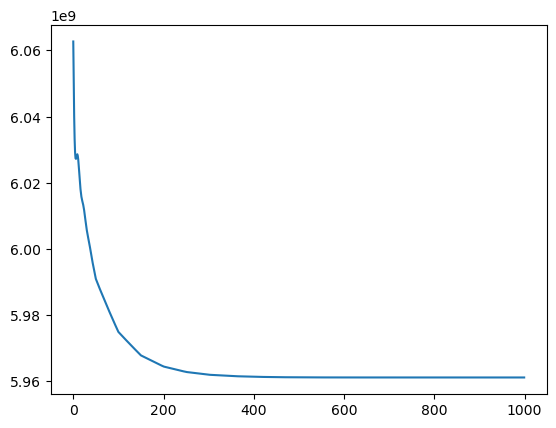

In [184]:
tqr

tensor([[ 1.0048e+00, -2.7481e-03,  3.8206e-03, -5.3598e-03],
        [-2.9054e-03,  9.9803e-01, -4.8871e-04, -5.2118e-03],
        [ 4.8216e-03,  4.8497e-03,  1.0049e+00, -4.7289e-03],
        [-8.9977e-04, -1.2465e-03,  1.4377e-03,  9.9482e-01]], device='cuda:0',
       requires_grad=True)